In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [74]:
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary

In [75]:
HIDDEN_UNITS = 256
INPUT_UNITS = 218

In [92]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden1 = nn.Linear(INPUT_UNITS, 2 * HIDDEN_UNITS)
        self.hidden_active1 = nn.ReLU()
        self.hidden2 = nn.Linear(2 * HIDDEN_UNITS, HIDDEN_UNITS)
        self.hidden_active2 = nn.ReLU()
        self.hidden3 = nn.Linear(HIDDEN_UNITS, HIDDEN_UNITS)
        self.hidden_active3 = nn.ReLU()
        self.hidden4 = nn.Linear(HIDDEN_UNITS, HIDDEN_UNITS)
        self.hidden_active4 = nn.ReLU()
        self.out = nn.Linear(HIDDEN_UNITS, 1)
        self.loss = nn.MSELoss()

    def forward(self, x):
        x = self.hidden1(x)
        x = self.hidden_active1(x)
        x = self.hidden2(x)
        x = self.hidden_active2(x)
        x = self.hidden3(x)
        x = self.hidden_active3(x)
        x = self.hidden4(x)
        x = self.hidden_active4(x)
        x = self.out(x)
        return x

In [93]:
model = Net()
summary(model, input_size=(1, 218))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 1]                    --
├─Linear: 1-1                            [1, 512]                  112,128
├─ReLU: 1-2                              [1, 512]                  --
├─Linear: 1-3                            [1, 256]                  131,328
├─ReLU: 1-4                              [1, 256]                  --
├─Linear: 1-5                            [1, 256]                  65,792
├─ReLU: 1-6                              [1, 256]                  --
├─Linear: 1-7                            [1, 256]                  65,792
├─ReLU: 1-8                              [1, 256]                  --
├─Linear: 1-9                            [1, 1]                    257
Total params: 375,297
Trainable params: 375,297
Non-trainable params: 0
Total mult-adds (M): 0.38
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.50
Estimated Total Size (MB)

In [94]:
X = pd.read_csv('X_10_no_bombs.csv')
y = pd.read_csv('y_10_no_bombs.csv')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [95]:
print(X.shape)
X.dropna(inplace=True)
print(X.shape)

(35405, 218)
(35405, 218)


In [96]:
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [97]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [98]:
X_train.shape

torch.Size([28324, 218])

In [99]:
BATCH_SIZE = 32
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
loss_list = []
def train(model, train_loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    loss_list.append(running_loss / len(train_loader))

In [100]:
model = Net()
for i in tqdm(range(100)):   
    train(model, train_loader, optim.Adam(model.parameters(), lr=0.01), model.loss)

100%|██████████| 100/100 [05:57<00:00,  3.58s/it]


In [101]:
loss_list

[23129.98443916958,
 4925.2576638043065,
 4646.482885201413,
 4120.052220536139,
 3961.8714409821728,
 3886.954807427882,
 3730.8756266781224,
 3715.5655877175773,
 3744.366905918509,
 3654.8941954877523,
 3622.762282498534,
 3579.516376951747,
 3576.8257245479267,
 3632.843271156466,
 3473.4072413735144,
 3477.4841396770953,
 3359.6778873073326,
 3474.900165842026,
 3392.022527724841,
 3362.8688723045334,
 3364.673560700083,
 3325.462498202012,
 3281.2984921216425,
 3263.63915354296,
 3276.0808586998933,
 3244.3280334128212,
 3329.0179747157385,
 3288.3194302802162,
 3299.6495951013158,
 3326.2392840245507,
 3303.649431870161,
 3270.7052904391667,
 3301.4224797027105,
 3276.5900628152335,
 3278.4970956978896,
 3232.5668601903635,
 3281.559675918476,
 3275.1685170675237,
 3242.4384112218163,
 3238.626496721875,
 3288.721264496883,
 3261.15945889234,
 3246.019592147379,
 3231.3577331129636,
 3270.165940364381,
 3255.0014741781333,
 3231.5953652272106,
 3258.0624480581178,
 3269.99107123

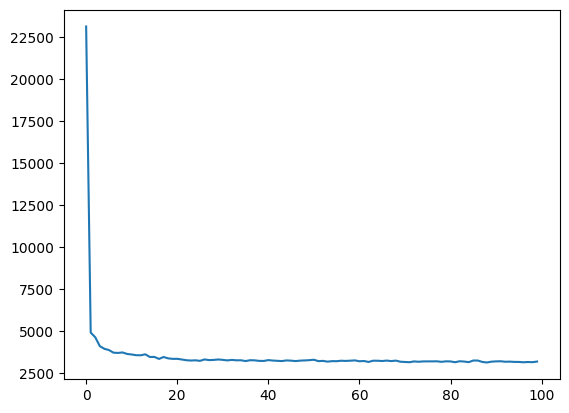

In [102]:
plt.plot(loss_list)

In [103]:
# test
model.eval()
predictions = []
for x in X_test:
    x = x.reshape(1, 218)
    x = torch.tensor(x, dtype=torch.float32)
    y_pred = model.forward(x)
    predictions.append(y_pred.item())

model.score = model.loss(torch.tensor(predictions, dtype=torch.float32), y_test.squeeze())
print(model.score.item())

C:\Users\charl\AppData\Local\Temp\ipykernel_7808\2067007474.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)


3427.81201171875


In [104]:
r = np.corrcoef(predictions, y_test.squeeze())
print(r[0][1] ** 2)

0.8861103528129151


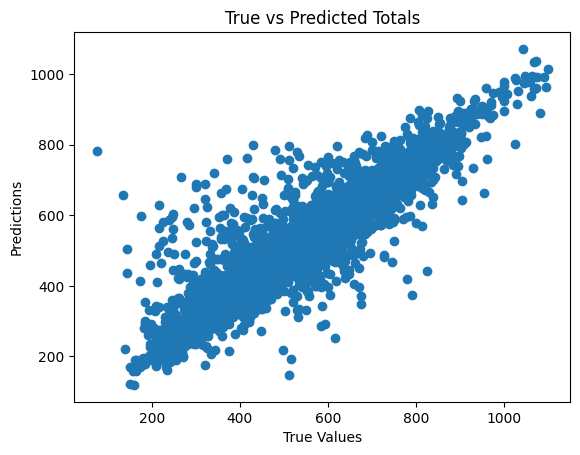

In [105]:
plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs Predicted Totals')
plt.show()